In [19]:
pip install pandasql

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals())

In [21]:
bio_prod = pd.read_csv('biofuel-production.csv')
wind_cap = pd.read_csv('cumulative-installed-wind-energy-capacity-gigawatts.csv')
hydro_share_nrg = pd.read_csv('hydro-share-energy.csv')
hydro_cons = pd.read_csv('hydropower-consumption.csv')
geo_cap = pd.read_csv('installed-geothermal-capacity.csv')
pv_cap = pd.read_csv('installed-solar-PV-capacity.csv')
renew_cons = pd.read_csv('modern-renewable-energy-consumption.csv')
renew_prod = pd.read_csv('modern-renewable-prod.csv')
renew_share_nrg = pd.read_csv('renewable-share-energy.csv')
hydro_share = pd.read_csv('share-electricity-hydro.csv')
renew_share = pd.read_csv('share-electricity-renewables.csv')
solar_share = pd.read_csv('share-electricity-solar.csv')
wind_share = pd.read_csv('share-electricity-wind.csv')
solar_cons = pd.read_csv('solar-energy-consumption.csv')
solar_share_nrg = pd.read_csv('solar-share-energy.csv')
wind_gen = pd.read_csv('wind-generation.csv')
wind_share = pd.read_csv('wind-share-energy.csv')

**What are we going to achieve**

I will be using matplotlib to generate a wide variety of graphs and do some exploratory analysis of the renewable energy dataset.

Graph types:
*   Histogram
*   Line
*   Bar
*   Scatter
*   Pie












# **Histogram**

First I will use Pandas & SQL to generate a new dataframe for the share of renewable electricity for each country in the year 2020. The table includes some aggregate records for different continents and another record for the whole world that I need to filter out to get only country-level data.

In [22]:
renew_2020 = mysql("""
SELECT
    Entity,
    Code,
    "Renewables (% electricity)" AS Share
FROM renew_share
WHERE
    Year = 2020
AND
    Code IS NOT NULL
AND
    Code <> 'OWID_WRL'
""")

Now I can plot the histogram for share of renewable electricity.

(array([64., 29., 24., 13., 17., 11., 15.,  8., 10., 18.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

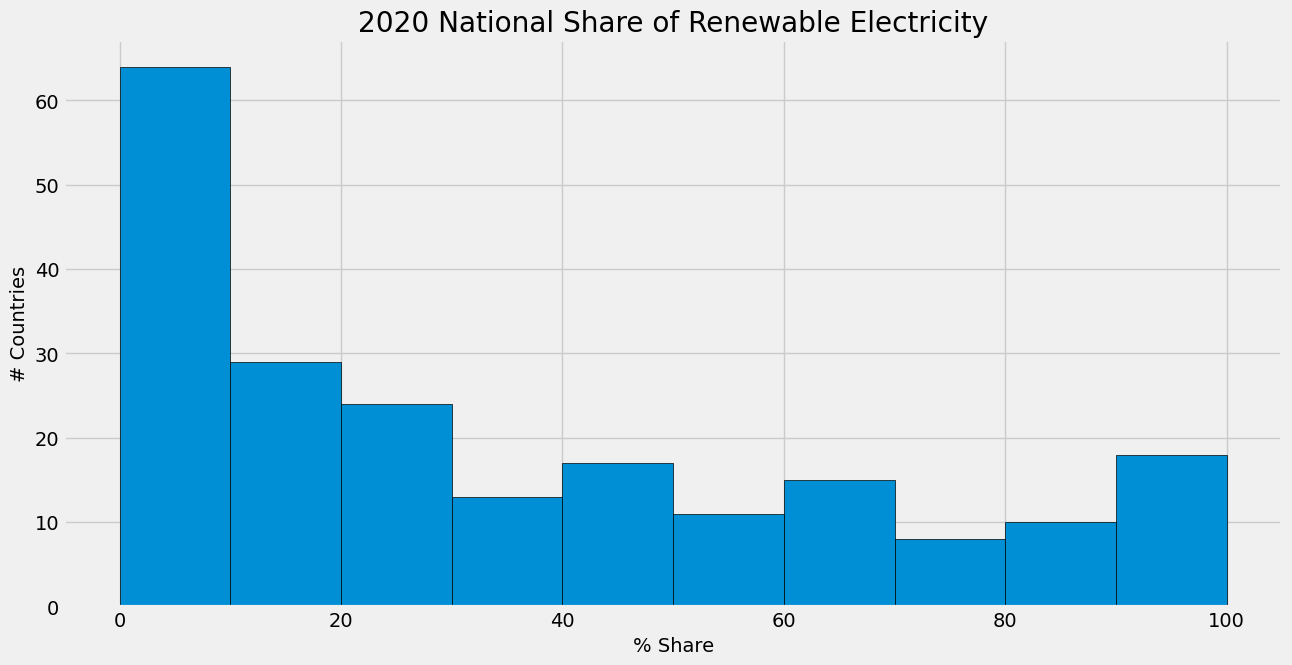

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (14,7))
plt.title("2020 National Share of Renewable Electricity")
plt.xlabel("% Share", fontsize = 14)
plt.ylabel("# Countries", fontsize = 14)

plt.hist(renew_2020['Share'], 10, edgecolor = 'black')

This histogram is interesting. It shows us that there are a lot of countries with very little renewable electricity generation. As the renewable electricity share increases, the number of countries tends to decrease, except in the final 90-100% bin where there is a surprising tick upwards.

It may be that when a country gets high enough renewable generation, it might make sense to just cut out fossil fuels altogether. This inflection point may be around 80-90% renewable electricity share. I'm curious which countries are in that final bin.

Let's run a query to find all the countries in the final bin.

In [24]:
mysql("""
SELECT
    Entity,
    Code,
    "Renewables (% electricity)" AS Share
FROM renew_share
WHERE
    Year = 2020
AND
    Share >= 90
""")

,Entity,Code,Share
0,Albania,ALB,100.000
1,Bhutan,BTN,100.000
2,Central African Republic,CAF,100.000
3,Costa Rica,CRI,98.799
4,Democratic Republic of Congo,COD,99.676
5,Eswatini,SWZ,93.939
6,Ethiopia,ETH,99.929
7,Iceland,ISL,100.000
8,Kenya,KEN,92.958
9,Kyrgyzstan,KGZ,92.848


This list of countries is an interesting mix. There are a lot of smaller countries as well as poor and wealthy countries. It kind of makes sense that a small country might be able to get to 90-100% renewable electricity if they happen to have an abundant renewable resource. This would be more difficult for larger countries that need to rely on more than just a single electricity source.

Countries like Albania, Central African Republic, Ethiopia and Bhutan get nearly all their electricity from hydroelectric sources. Other countries like Iceland have huge geothermal energy resources. While other countries like Costa Rica have a mix of hydro, geothermal, wind and biomass resources. We have a good mix of countries that happen to have big renewable resources, or are poorer countries that don't use a lot of electricity to begin with.

If I had access to gdp per capita data on the countries, I'd be interested to see if there was some clustering with renewable electricity share.

#  **Line Graph**

Next let's look at a line graph comparing the growth of wind capacity of China and the USA

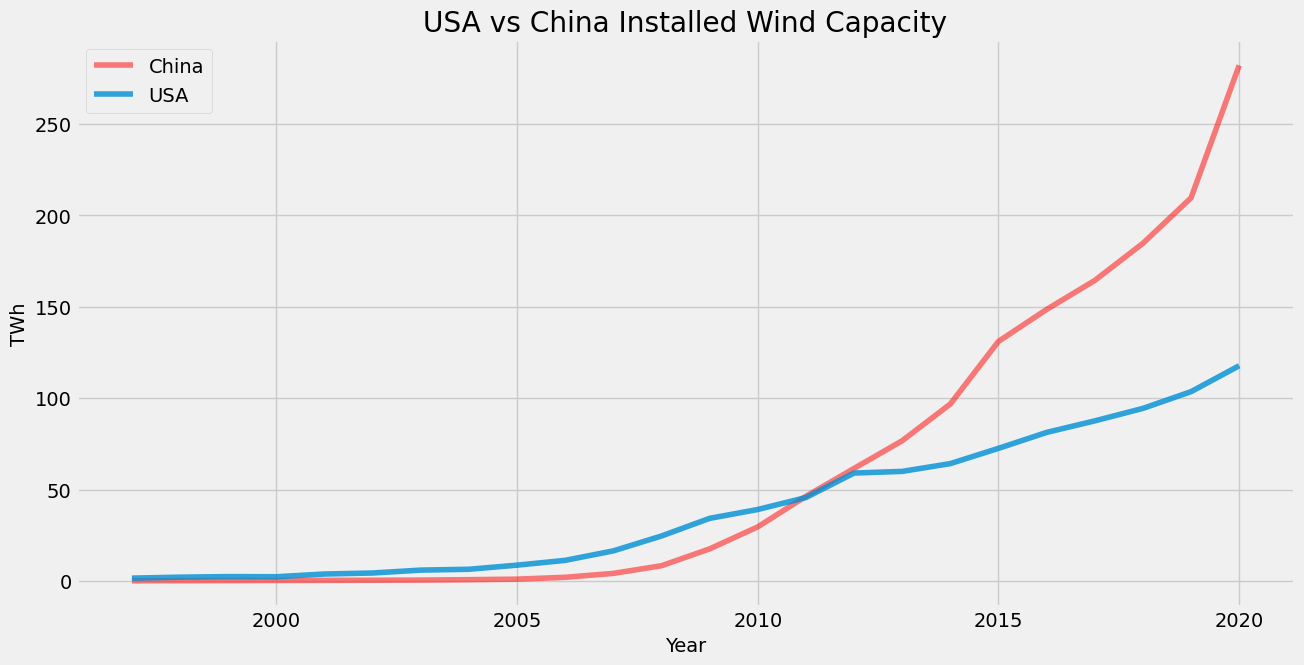

In [25]:
wind_cap.rename(columns = {'Wind Capacity':'capacity'}, inplace = True)
usa = wind_cap[wind_cap.Entity == 'United States']
chn = wind_cap[wind_cap.Entity == 'China']

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,7))
plt.title('USA vs China Installed Wind Capacity')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("TWh", fontsize = 14)

plt.plot(chn.Year, chn.capacity, label = 'China', color = 'r', alpha = 0.5)
plt.plot(usa.Year, usa.capacity, label = 'USA', alpha = 0.8)
plt.legend()

Here we can see that USA wind capacity was larger, up until just past 2010. Then China overtook the USA and continued rapid growth while the USA maintained more linear capacity growth.

I'm interested in seeing how the ratio of China:USA wind capacity changes over time.

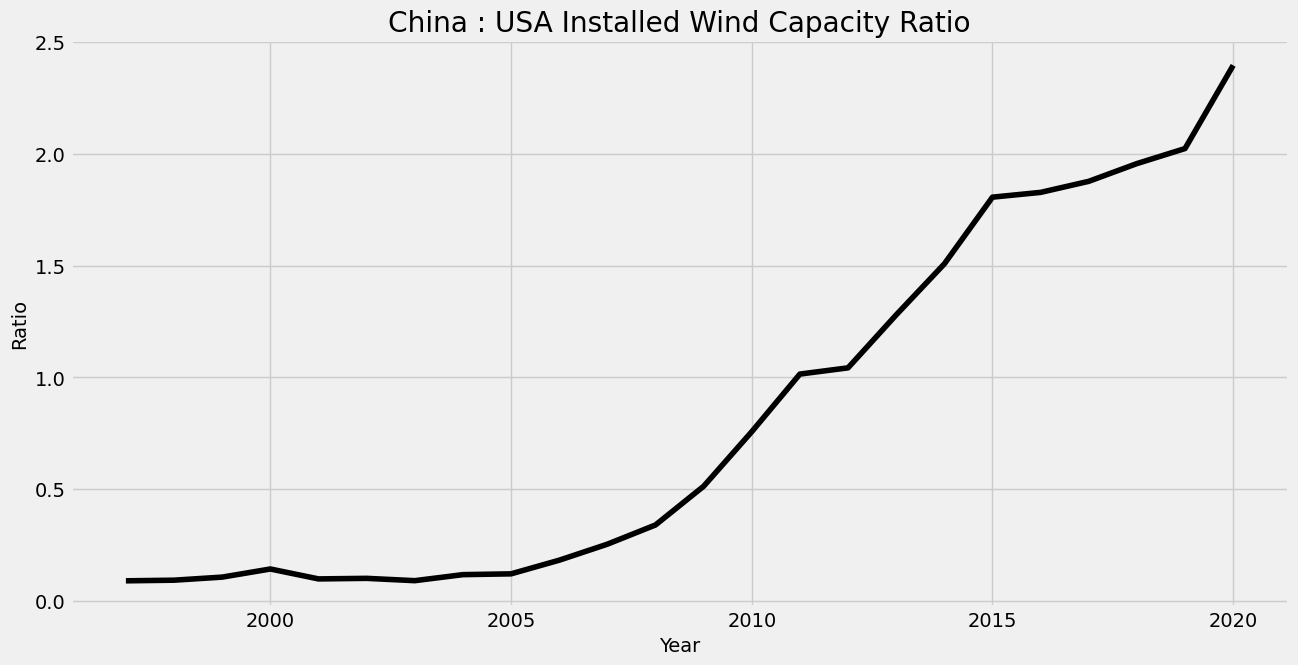

In [26]:
combo = pd.merge(usa, chn, on='Year') # create new df with usa & china production values
combo['ratio'] = combo['capacity_y']/combo['capacity_x'] # create new column to compute ratio of china:usa capacity

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,7))
plt.title('China : USA Installed Wind Capacity Ratio')
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Ratio", fontsize = 14)

plt.plot(combo.Year, combo.ratio, color = 'black')

This graph shows the ratio of China : USA installed wind capacity. You can see China's upward trajectory compared to the USA really starts around 2008. They catch up to the USA around 2011 when the ratio is 1.0 and continue relative growth all the way to 2020 where China has nearly 2.5x the USA's wind capacity.

# **Bar Graph**

Let's generate a bar graph to visualize the top 10 countries in 2020 with the most solar energy consumption. I could do the filtering using SQL, but I think I'll use pandas instead.

<BarContainer object of 10 artists>

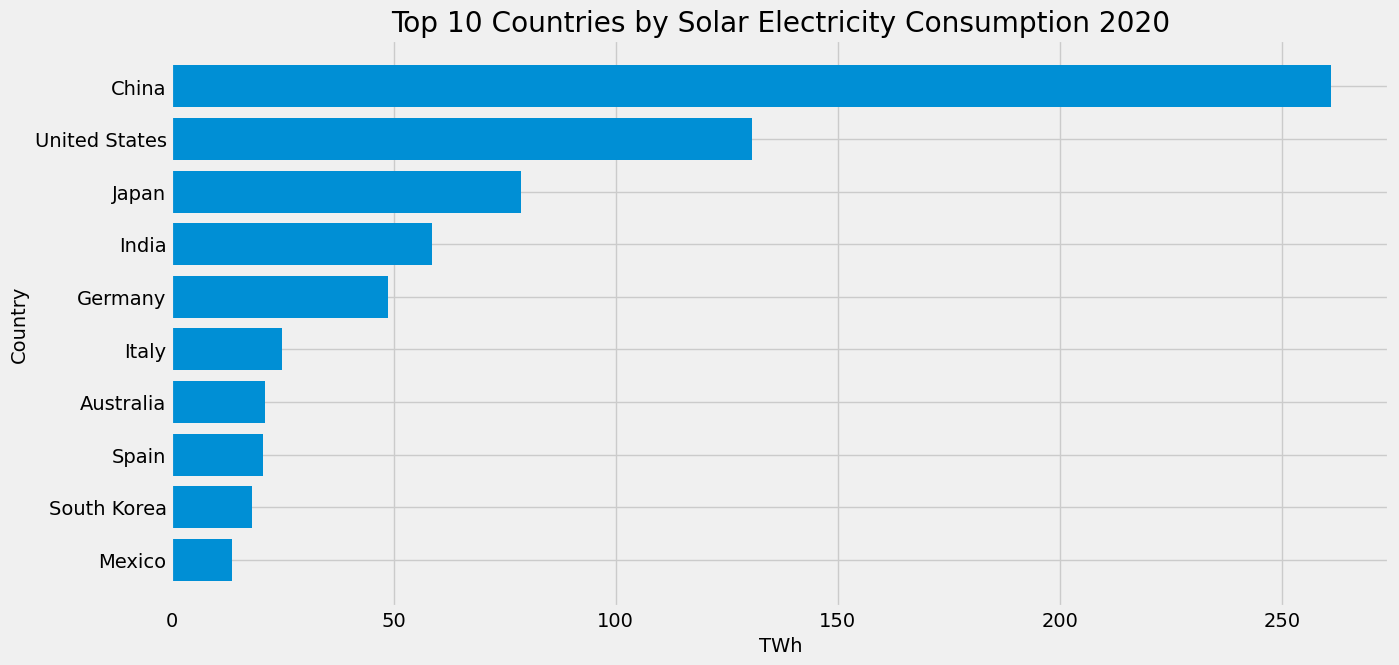

In [27]:
# create new df for 2020 solar consumption data, filter out non-country rows
sc2020 = solar_cons[(solar_cons.Year == 2020) & (solar_cons.Entity != "World") & (solar_cons.Code.notnull())]
sc2020 = sc2020.rename(columns = {"Electricity from solar (TWh)":"TWh"}) # rename TWh column

# filter top 10 countries
top10 = sc2020.sort_values(by = 'TWh').tail(10)

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,7))
plt.title('Top 10 Countries by Solar Electricity Consumption 2020')
plt.ylabel("Country", fontsize = 14)
plt.xlabel("TWh", fontsize = 14)

plt.barh(top10.Entity, top10.TWh)

This graph clearly shows how China's consumption of solar electricity dwarfs the rest of the countries. There appears to be a significant drop in consumption over the top 6 countries.

# **Scatter Plot**

I want to see if wind power and solar power are correlated with each other. My hypothesis is that countries that push for more renewables (outside of hydro) will tend to try and build both PV and wind generation capacity and there should be a positive correlation.

equation of trendline: y=1.082553x+(-0.263333)


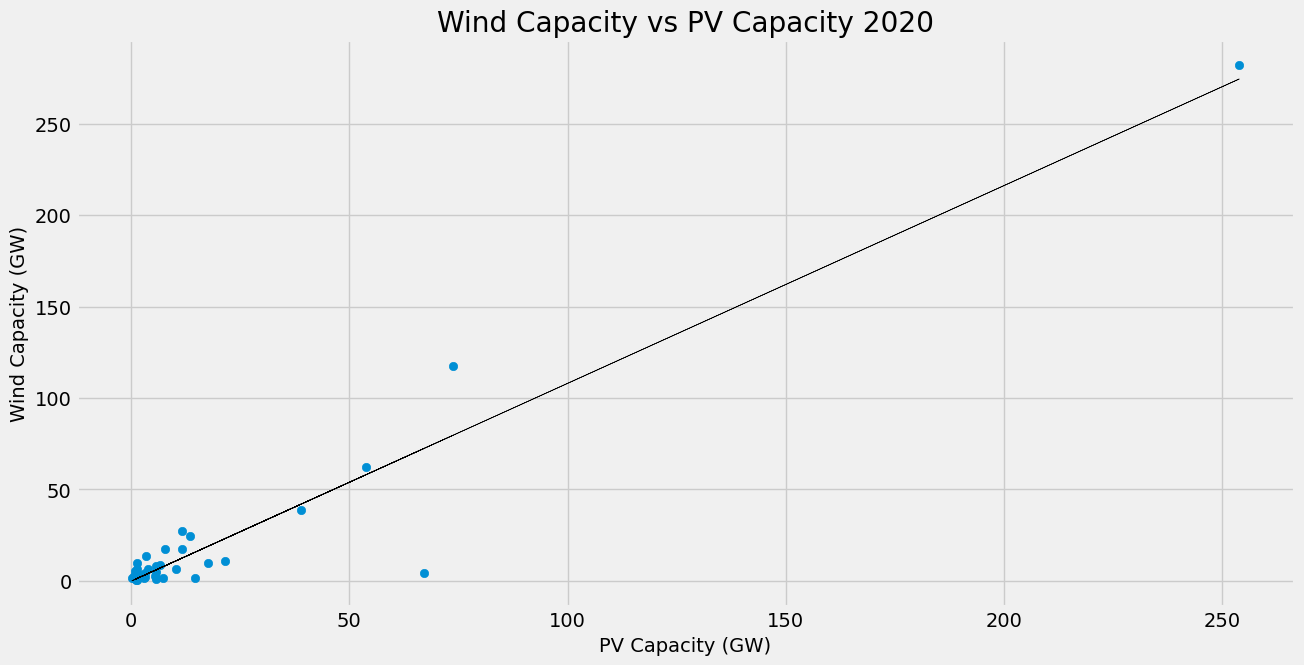

In [28]:
# Filter wind capacity and pv capacity dataframes for countries in 2020
wc2020 = wind_cap[(wind_cap.Year == 2020) & (wind_cap.Entity != "World") & (wind_cap.Code.notnull())]
pv2020 = pv_cap[(pv_cap.Year == 2020) & (pv_cap.Entity != "World") & (pv_cap.Code.notnull())]

# join both dataframes together
wcpv = pd.merge(wc2020, pv2020, on='Code')
wcpv = wcpv.rename(columns = {"Solar Capacity":"pvcap"})


plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,7))
plt.title('Wind Capacity vs PV Capacity 2020')
plt.ylabel("Wind Capacity (GW)", fontsize = 14)
plt.xlabel("PV Capacity (GW)", fontsize = 14)

plt.scatter(wcpv.pvcap, wcpv.capacity)

# add trendline:
z = np.polyfit(wcpv.pvcap, wcpv.capacity, 1)
p = np.poly1d(z)
plt.plot(wcpv.pvcap, p(wcpv.pvcap), linewidth = 0.5, color = 'black')

print("equation of trendline: y=%.6fx+(%.6f)"%(z[0],z[1]))

There does appear to be a positive correlation, as suspected with a slope of almost 1, implying that on average there is a GW of wind capacity installed for every GW of PV capacity installed.

That outlier point in the top right is China and it's so far out that it's difficult to see details with the other countries. Let's try replotting everything without China.

equation of trendline: y=0.926079x+(1.317177)


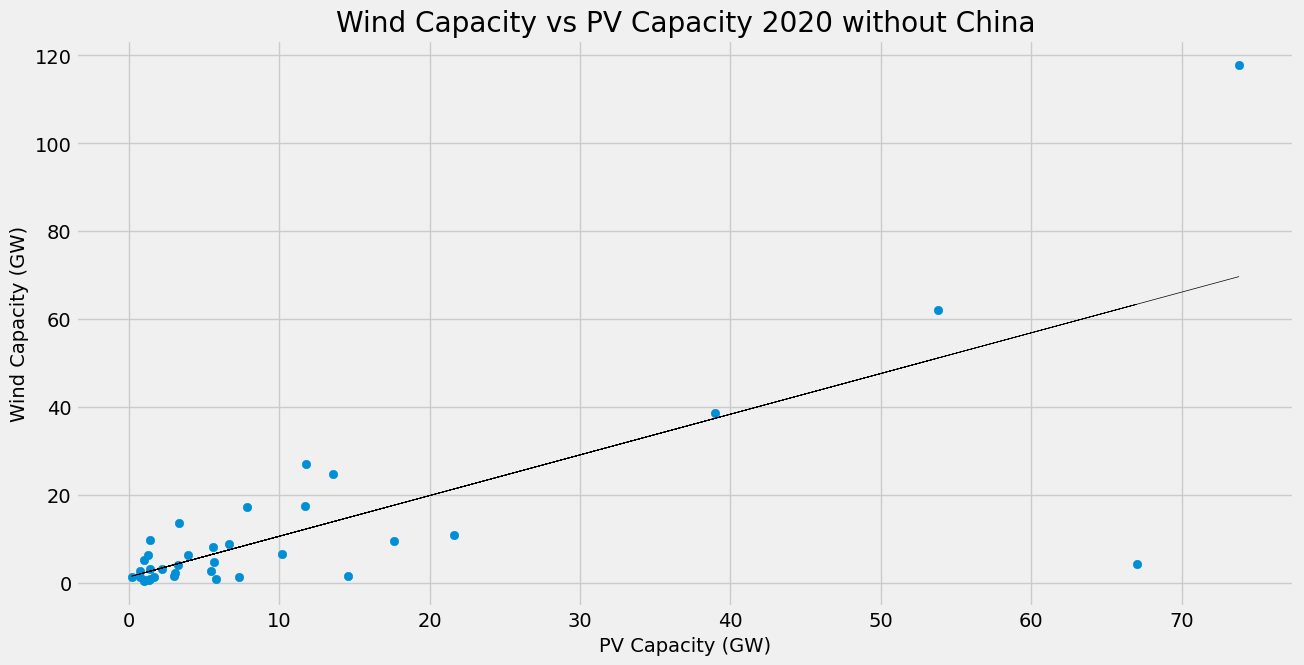

In [29]:
# filter out China
wcpv2 = wcpv[(wcpv.Code != 'CHN')]

plt.style.use("fivethirtyeight")
plt.figure(figsize = (14,7))
plt.title('Wind Capacity vs PV Capacity 2020 without China')
plt.ylabel("Wind Capacity (GW)", fontsize = 14)
plt.xlabel("PV Capacity (GW)", fontsize = 14)

plt.scatter(wcpv2.pvcap, wcpv2.capacity)

# add trendline:
z = np.polyfit(wcpv2.pvcap, wcpv2.capacity, 1)
p = np.poly1d(z)
plt.plot(wcpv2.pvcap, p(wcpv2.pvcap), linewidth = 0.5, color = 'black')

print("equation of trendline: y=%.6fx+(%.6f)"%(z[0],z[1]))

Filtering out China allows us to zoom in on the remaining countries and the positive correlation survives with a trendline slope of 0.926, so still close to 1.

That outlier point in the bottom right with high PV capacity and low wind capacity is Japan. Japan had a huge surge in PV installation following the Fukushima disaster in 2011, but this was not matched with a big surge in wind generation. I speculate this is because PV is easier and faster to deploy with smaller distributed systems either retrofitted on rooftops or built on unused land. Wind generation is more tricky, being more site specific, with longer lead times and needing larger scales to be economical.

There is a push for Japan to build more offshore wind over the next few decades. They are targeting 45 GW of wind capacity by 2040. Offshore wind is very capital intensive and takes a long time to build. I'm not sure if Japan will migrate towards the global trendline over the next few decades. The offshore wind projects will help, but PV installation may continue to grow and maintain its lead.

# **Pie Chart**

For our pie chart, let's try and zoom out and see what the worldwide renewable energy mix looks like. Renewable Energy Components:
*   Biomass
*   Hydro
*   Geothermal
*   Solar
*   Wind

([<matplotlib.patches.Wedge at 0x7f7331f89250>,
 [Text(0.8611389740200438, 0.6844265244887187, 'Wind'),
  Text(-0.1463806841546635, 1.090216811146486, 'Solar'),
  Text(-0.7814486859130367, 0.7741692006821173, 'Geo/Bio/Other'),
  Text(-0.2642825639391584, -1.067780280019136, 'Hydro')],
 [Text(0.4697121676472965, 0.37332355881202833, '21.4%'),
  Text(-0.07984400953890736, 0.5946637151708105, '11.5%'),
  Text(-0.4262447377707473, 0.422274109462973, '9.4%'),
  Text(-0.14415412578499548, -0.5824256072831651, '57.7%')])

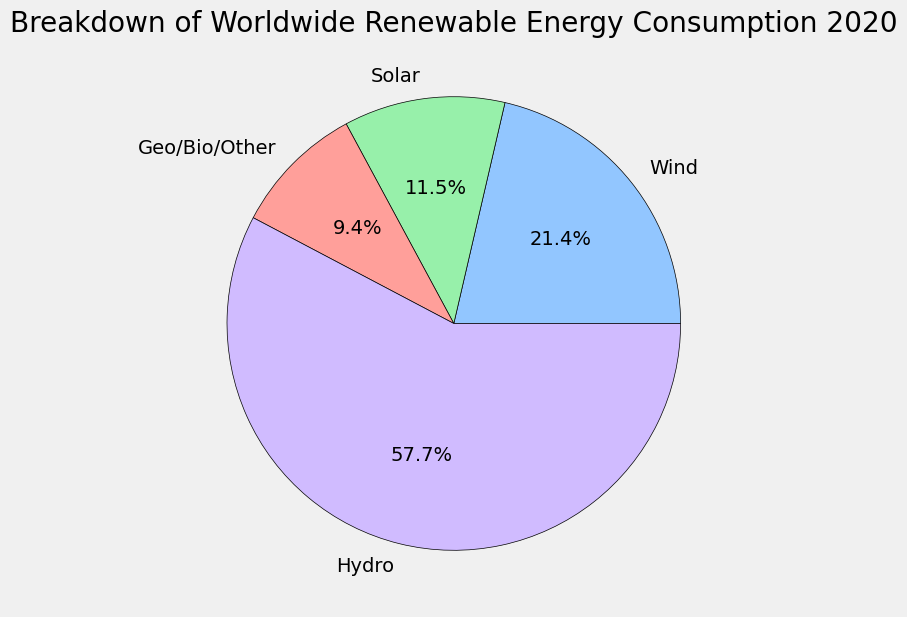

In [30]:
# Filter renewable consumption dataframe for the World record in 2020
world = renew_cons[(renew_cons.Year == 2020) & (renew_cons.Entity == 'World')]
# Drop all columns not containing consumption data so we can create a pie chart
world.drop(['Entity', 'Code', 'Year'], axis=1, inplace=True)

plt.style.use("seaborn-v0_8-pastel")
plt.figure(figsize = (7,7))
plt.title('Breakdown of Worldwide Renewable Energy Consumption 2020')

plt.pie(world.iloc[0], labels = ['Wind', 'Solar', 'Geo/Bio/Other', 'Hydro'], autopct='%1.1f%%', wedgeprops = {'edgecolor':'black'})

Here we can see that Hydropower represents the largest source of renewable energy worldwide, followed by Wind then Solar. Geothermal, Biomass and other renewables make up the last category.

# **Summary**

In this notebook I did some brief exploratory analysis of global renewable energy and made several different kinds of graphs